# FAIRFACE - Age Estimation and Gender Classification with Multi-Task Learning

## Imports

In [1]:
import glob
import re
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Dataset

In [2]:
trn_df = pd.read_csv('fairface_label_train.csv')
val_df = pd.read_csv('fairface_label_val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [3]:
class GenderAgeClass(Dataset):
    """
    Takes a filename as input and returns the corresponding image, gender, and scaled age.
    """
    def __init__(self, df, im_size=224, tfms=None): 
        self.df = df
        self.im_size = im_size # Imagenet standards
        # http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/models.html
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Imagenet standards
        self.dict_age = {'0-2': 0,
                         '3-9': 1,
                         '10-19': 2,
                         '20-29': 3,
                         '30-39': 4,
                         '40-49': 5,
                         '50-59': 6,
                         '60-69': 7,
                         'more than 70': 8} 
        
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, float(self.dict_age[age]), gen

    def preprocess_image(self, im):
        im = cv2.resize(im, (self.im_size, self.im_size))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        #preprocess images, ages and genders
        ims, ages, genders = [], [], []

        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)
            ages.append(age)
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device) for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages.type(torch.LongTensor).to(device), genders
    
    def get_age(self, age):
        key_list = list(self.dict_age.keys())
        val_list = list(self.dict_age.values())
        position = val_list.index(age)
        return key_list[position]

In [4]:
def display_image(im, title="sth", cmap='gray', fig_size=(5, 5)):
    """
    Display images.
    """
    plt.figure(figsize=fig_size)       
    plt.title(title)
    plt.imshow(im, cmap=cmap)        
    plt.show()

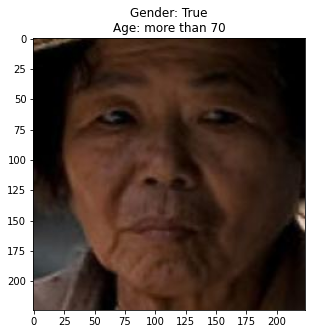

In [5]:
train = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, age, gen = val[10]
# false => male & true => female
display_image(im, title=f'Gender: {gen}\nAge: {train.get_age(age)}')

In [6]:
train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True, collate_fn=train.collate_fn)
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
print(c)
print(b)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       device='cuda:0')
tensor([1, 3, 6, 1, 4, 3, 2, 5, 3, 2, 3, 6, 3, 1, 0, 3, 3, 3, 8, 5, 4, 4, 3, 1,
        5, 4, 2, 5, 4, 1, 0, 4], device='cuda:0')


In [7]:
class ageGenderClassifier(nn.Module):
    """
    ANN multi-task learning class for VGG16, RESNET18 and RESNET34
    """
    def __init__(self, num_units=512, num_age_classes=9, dropout=0.1):

        super(ageGenderClassifier, self).__init__()

        self.age_classifier = nn.Sequential(
            nn.Linear(num_units,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(128, num_age_classes)
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(num_units,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        #print(x.shape)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return gender, age

## Model vgg16

In [9]:
model = models.vgg16(pretrained=True)
num_features = model.classifier[0].in_features

model.classifier = ageGenderClassifier(num_units=num_features)
   
gender_criterion = nn.BCELoss()
age_criterion = nn.CrossEntropyLoss()
    
loss_functions = gender_criterion, age_criterion
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)   
model = model.to(device)

## Model resnet18

In [24]:
model = models.resnet18(pretrained=True) 

num_features = model.fc.in_features 
model.fc = ageGenderClassifier()
   
gender_criterion = nn.BCELoss()
age_criterion = nn.CrossEntropyLoss()
    
loss_functions = gender_criterion, age_criterion
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)   
model = model.to(device)

## Model resnet34

In [34]:
model = models.resnet34(pretrained=True)

num_features = model.fc.in_features 
model.fc = ageGenderClassifier()
   
gender_criterion = nn.BCELoss()
age_criterion = nn.CrossEntropyLoss()
    
loss_functions = gender_criterion, age_criterion
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)   
model = model.to(device)

## Model

In [88]:
def train_batch(data, model, optimizer, criteria, fst_age_loss=1, fst_gender_loss=3):
    model.train()    
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims) 
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    #total_loss = (gender_loss/fst_gender_loss) + (age_loss/fst_age_loss)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum() / pred_gender.shape[0]
    age_acc = (pred_age.argmax(dim=1) == age).float().sum() / pred_gender.shape[0]
    return total_loss, gender_acc, age_acc


def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum() / pred_gender.shape[0]
    age_acc = (pred_age.argmax(dim=1) == age).float().sum() / pred_gender.shape[0]
    return total_loss, gender_acc, age_acc

## Train

In [28]:
%load_ext tensorboard
%tensorboard --logdir=runs --port 8678

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [71]:
writer = SummaryWriter("runs/VGG16")
#writer = SummaryWriter("runs/RESNET34")

In [89]:
torch.cuda.empty_cache()
#im = cv2.imread('me.jpg')
test_data = train.preprocess_image(im).to(device)

batch_size = 32
n_epochs = 10

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train.collate_fn)
test_loader = DataLoader(val, batch_size=batch_size, collate_fn=val.collate_fn)

_train_losses = []
_val_losses = []

for epoch in range(n_epochs):
    for n_iter, data in enumerate(train_loader):
        loss, gender_acc, age_acc = train_batch(data, model, optimizer, loss_functions)
        _train_losses.append(n_iter)
        writer.add_scalar('Loss/train', loss.item(), len(_train_losses)) 
        writer.add_scalar('Acc_Gender/train', gender_acc, len(_train_losses))
        writer.add_scalar('Acc_Age/train', age_acc, len(_train_losses))
        
        print(epoch, " / ", n_iter)
        ##################################################################
        #model.eval()
        #gender, age = model(test_data)
        #pred_gender = gender.cpu().detach().numpy()
        #pred_age = torch.argmax(age, dim=1).cpu().detach().numpy()
        #print('Predicted gender:', np.where(pred_gender[0][0] < 0.5, 'Male','Female'), pred_gender[0][0])
        #print('Predicted age:', train.get_age(pred_age)) 

    print("################################## Test ##################################")

    for n_iter, data in enumerate(test_loader):
        loss, gender_acc, age_acc = validate_batch(data, model, loss_functions)
        _val_losses.append(n_iter)
        writer.add_scalar('Loss/test', loss.item(), len(_val_losses))
        writer.add_scalar('Acc_Gender/test', gender_acc, len(_val_losses))
        writer.add_scalar('Acc_Age/test', age_acc, len(_val_losses))
        

0  /  0
0  /  1
0  /  2
0  /  3
0  /  4
0  /  5
0  /  6
0  /  7
0  /  8
0  /  9
0  /  10
0  /  11
0  /  12
0  /  13
0  /  14
0  /  15
0  /  16
0  /  17
0  /  18
0  /  19
0  /  20
0  /  21
0  /  22
0  /  23
0  /  24
0  /  25
0  /  26
0  /  27
0  /  28
0  /  29
0  /  30
0  /  31
0  /  32
0  /  33
0  /  34
0  /  35
0  /  36
0  /  37
0  /  38
0  /  39
0  /  40
0  /  41
0  /  42
0  /  43
0  /  44
0  /  45
0  /  46
0  /  47
0  /  48
0  /  49
0  /  50
0  /  51
0  /  52
0  /  53
0  /  54
0  /  55
0  /  56
0  /  57
0  /  58
0  /  59
0  /  60
0  /  61
0  /  62
0  /  63
0  /  64
0  /  65
0  /  66
0  /  67
0  /  68
0  /  69
0  /  70
0  /  71
0  /  72
0  /  73
0  /  74
0  /  75
0  /  76
0  /  77
0  /  78
0  /  79
0  /  80
0  /  81
0  /  82
0  /  83
0  /  84
0  /  85
0  /  86
0  /  87
0  /  88
0  /  89
0  /  90
0  /  91
0  /  92
0  /  93
0  /  94
0  /  95
0  /  96
0  /  97
0  /  98
0  /  99
0  /  100
0  /  101
0  /  102
0  /  103
0  /  104
0  /  105
0  /  106
0  /  107
0  /  108
0  /  109
0  /  110


0  /  831
0  /  832
0  /  833
0  /  834
0  /  835
0  /  836
0  /  837
0  /  838
0  /  839
0  /  840
0  /  841
0  /  842
0  /  843
0  /  844
0  /  845
0  /  846
0  /  847
0  /  848
0  /  849
0  /  850
0  /  851
0  /  852
0  /  853
0  /  854
0  /  855
0  /  856
0  /  857
0  /  858
0  /  859
0  /  860
0  /  861
0  /  862
0  /  863
0  /  864
0  /  865
0  /  866
0  /  867
0  /  868
0  /  869
0  /  870
0  /  871
0  /  872
0  /  873
0  /  874
0  /  875
0  /  876
0  /  877
0  /  878
0  /  879
0  /  880
0  /  881
0  /  882
0  /  883
0  /  884
0  /  885
0  /  886
0  /  887
0  /  888
0  /  889
0  /  890
0  /  891
0  /  892
0  /  893
0  /  894
0  /  895
0  /  896
0  /  897
0  /  898
0  /  899
0  /  900
0  /  901
0  /  902
0  /  903
0  /  904
0  /  905
0  /  906
0  /  907
0  /  908
0  /  909
0  /  910
0  /  911
0  /  912
0  /  913
0  /  914
0  /  915
0  /  916
0  /  917
0  /  918
0  /  919
0  /  920
0  /  921
0  /  922
0  /  923
0  /  924
0  /  925
0  /  926
0  /  927
0  /  928
0  /  929
0  /  930


0  /  1592
0  /  1593
0  /  1594
0  /  1595
0  /  1596
0  /  1597
0  /  1598
0  /  1599
0  /  1600
0  /  1601
0  /  1602
0  /  1603
0  /  1604
0  /  1605
0  /  1606
0  /  1607
0  /  1608
0  /  1609
0  /  1610
0  /  1611
0  /  1612
0  /  1613
0  /  1614
0  /  1615
0  /  1616
0  /  1617
0  /  1618
0  /  1619
0  /  1620
0  /  1621
0  /  1622
0  /  1623
0  /  1624
0  /  1625
0  /  1626
0  /  1627
0  /  1628
0  /  1629
0  /  1630
0  /  1631
0  /  1632
0  /  1633
0  /  1634
0  /  1635
0  /  1636
0  /  1637
0  /  1638
0  /  1639
0  /  1640
0  /  1641
0  /  1642
0  /  1643
0  /  1644
0  /  1645
0  /  1646
0  /  1647
0  /  1648
0  /  1649
0  /  1650
0  /  1651
0  /  1652
0  /  1653
0  /  1654
0  /  1655
0  /  1656
0  /  1657
0  /  1658
0  /  1659
0  /  1660
0  /  1661
0  /  1662
0  /  1663
0  /  1664
0  /  1665
0  /  1666
0  /  1667
0  /  1668
0  /  1669
0  /  1670
0  /  1671
0  /  1672
0  /  1673
0  /  1674
0  /  1675
0  /  1676
0  /  1677
0  /  1678
0  /  1679
0  /  1680
0  /  1681
0  /  1682

0  /  2337
0  /  2338
0  /  2339
0  /  2340
0  /  2341
0  /  2342
0  /  2343
0  /  2344
0  /  2345
0  /  2346
0  /  2347
0  /  2348
0  /  2349
0  /  2350
0  /  2351
0  /  2352
0  /  2353
0  /  2354
0  /  2355
0  /  2356
0  /  2357
0  /  2358
0  /  2359
0  /  2360
0  /  2361
0  /  2362
0  /  2363
0  /  2364
0  /  2365
0  /  2366
0  /  2367
0  /  2368
0  /  2369
0  /  2370
0  /  2371
0  /  2372
0  /  2373
0  /  2374
0  /  2375
0  /  2376
0  /  2377
0  /  2378
0  /  2379
0  /  2380
0  /  2381
0  /  2382
0  /  2383
0  /  2384
0  /  2385
0  /  2386
0  /  2387
0  /  2388
0  /  2389
0  /  2390
0  /  2391
0  /  2392
0  /  2393
0  /  2394
0  /  2395
0  /  2396
0  /  2397
0  /  2398
0  /  2399
0  /  2400
0  /  2401
0  /  2402
0  /  2403
0  /  2404
0  /  2405
0  /  2406
0  /  2407
0  /  2408
0  /  2409
0  /  2410
0  /  2411
0  /  2412
0  /  2413
0  /  2414
0  /  2415
0  /  2416
0  /  2417
0  /  2418
0  /  2419
0  /  2420
0  /  2421
0  /  2422
0  /  2423
0  /  2424
0  /  2425
0  /  2426
0  /  2427

1  /  413
1  /  414
1  /  415
1  /  416
1  /  417
1  /  418
1  /  419
1  /  420
1  /  421
1  /  422
1  /  423
1  /  424
1  /  425
1  /  426
1  /  427
1  /  428
1  /  429
1  /  430
1  /  431
1  /  432
1  /  433
1  /  434
1  /  435
1  /  436
1  /  437
1  /  438
1  /  439
1  /  440
1  /  441
1  /  442
1  /  443
1  /  444
1  /  445
1  /  446
1  /  447
1  /  448
1  /  449
1  /  450
1  /  451
1  /  452
1  /  453
1  /  454
1  /  455
1  /  456
1  /  457
1  /  458
1  /  459
1  /  460
1  /  461
1  /  462
1  /  463
1  /  464
1  /  465
1  /  466
1  /  467
1  /  468
1  /  469
1  /  470
1  /  471
1  /  472
1  /  473
1  /  474
1  /  475
1  /  476
1  /  477
1  /  478
1  /  479
1  /  480
1  /  481
1  /  482
1  /  483
1  /  484
1  /  485
1  /  486
1  /  487
1  /  488
1  /  489
1  /  490
1  /  491
1  /  492
1  /  493
1  /  494
1  /  495
1  /  496
1  /  497
1  /  498
1  /  499
1  /  500
1  /  501
1  /  502
1  /  503
1  /  504
1  /  505
1  /  506
1  /  507
1  /  508
1  /  509
1  /  510
1  /  511
1  /  512


1  /  1212
1  /  1213
1  /  1214
1  /  1215
1  /  1216
1  /  1217
1  /  1218
1  /  1219
1  /  1220
1  /  1221
1  /  1222
1  /  1223
1  /  1224
1  /  1225
1  /  1226
1  /  1227
1  /  1228
1  /  1229
1  /  1230
1  /  1231
1  /  1232
1  /  1233
1  /  1234
1  /  1235
1  /  1236
1  /  1237
1  /  1238
1  /  1239
1  /  1240
1  /  1241
1  /  1242
1  /  1243
1  /  1244
1  /  1245
1  /  1246
1  /  1247
1  /  1248
1  /  1249
1  /  1250
1  /  1251
1  /  1252
1  /  1253
1  /  1254
1  /  1255
1  /  1256
1  /  1257
1  /  1258
1  /  1259
1  /  1260
1  /  1261
1  /  1262
1  /  1263
1  /  1264
1  /  1265
1  /  1266
1  /  1267
1  /  1268
1  /  1269
1  /  1270
1  /  1271
1  /  1272
1  /  1273
1  /  1274
1  /  1275
1  /  1276
1  /  1277
1  /  1278
1  /  1279
1  /  1280
1  /  1281
1  /  1282
1  /  1283
1  /  1284
1  /  1285
1  /  1286
1  /  1287
1  /  1288
1  /  1289
1  /  1290
1  /  1291
1  /  1292
1  /  1293
1  /  1294
1  /  1295
1  /  1296
1  /  1297
1  /  1298
1  /  1299
1  /  1300
1  /  1301
1  /  1302

1  /  1957
1  /  1958
1  /  1959
1  /  1960
1  /  1961
1  /  1962
1  /  1963
1  /  1964
1  /  1965
1  /  1966
1  /  1967
1  /  1968
1  /  1969
1  /  1970
1  /  1971
1  /  1972
1  /  1973
1  /  1974
1  /  1975
1  /  1976
1  /  1977
1  /  1978
1  /  1979
1  /  1980
1  /  1981
1  /  1982
1  /  1983
1  /  1984
1  /  1985
1  /  1986
1  /  1987
1  /  1988
1  /  1989
1  /  1990
1  /  1991
1  /  1992
1  /  1993
1  /  1994
1  /  1995
1  /  1996
1  /  1997
1  /  1998
1  /  1999
1  /  2000
1  /  2001
1  /  2002
1  /  2003
1  /  2004
1  /  2005
1  /  2006
1  /  2007
1  /  2008
1  /  2009
1  /  2010
1  /  2011
1  /  2012
1  /  2013
1  /  2014
1  /  2015
1  /  2016
1  /  2017
1  /  2018
1  /  2019
1  /  2020
1  /  2021
1  /  2022
1  /  2023
1  /  2024
1  /  2025
1  /  2026
1  /  2027
1  /  2028
1  /  2029
1  /  2030
1  /  2031
1  /  2032
1  /  2033
1  /  2034
1  /  2035
1  /  2036
1  /  2037
1  /  2038
1  /  2039
1  /  2040
1  /  2041
1  /  2042
1  /  2043
1  /  2044
1  /  2045
1  /  2046
1  /  2047

1  /  2702
1  /  2703
1  /  2704
1  /  2705
1  /  2706
1  /  2707
1  /  2708
1  /  2709
################################## Test ##################################
2  /  0
2  /  1
2  /  2
2  /  3
2  /  4
2  /  5
2  /  6
2  /  7
2  /  8
2  /  9
2  /  10
2  /  11
2  /  12
2  /  13
2  /  14
2  /  15
2  /  16
2  /  17
2  /  18
2  /  19
2  /  20
2  /  21
2  /  22
2  /  23
2  /  24
2  /  25
2  /  26
2  /  27
2  /  28
2  /  29
2  /  30
2  /  31
2  /  32
2  /  33
2  /  34
2  /  35
2  /  36
2  /  37
2  /  38
2  /  39
2  /  40
2  /  41
2  /  42
2  /  43
2  /  44
2  /  45
2  /  46
2  /  47
2  /  48
2  /  49
2  /  50
2  /  51
2  /  52
2  /  53
2  /  54
2  /  55
2  /  56
2  /  57
2  /  58
2  /  59
2  /  60
2  /  61
2  /  62
2  /  63
2  /  64
2  /  65
2  /  66
2  /  67
2  /  68
2  /  69
2  /  70
2  /  71
2  /  72
2  /  73
2  /  74
2  /  75
2  /  76
2  /  77
2  /  78
2  /  79
2  /  80
2  /  81
2  /  82
2  /  83
2  /  84
2  /  85
2  /  86
2  /  87
2  /  88
2  /  89
2  /  90
2  /  91
2  /  92
2  /  93
2

2  /  814
2  /  815
2  /  816
2  /  817
2  /  818
2  /  819
2  /  820
2  /  821
2  /  822
2  /  823
2  /  824
2  /  825
2  /  826
2  /  827
2  /  828
2  /  829
2  /  830
2  /  831
2  /  832
2  /  833
2  /  834
2  /  835
2  /  836
2  /  837
2  /  838
2  /  839
2  /  840
2  /  841
2  /  842
2  /  843
2  /  844
2  /  845
2  /  846
2  /  847
2  /  848
2  /  849
2  /  850
2  /  851
2  /  852
2  /  853
2  /  854
2  /  855
2  /  856
2  /  857
2  /  858
2  /  859
2  /  860
2  /  861
2  /  862
2  /  863
2  /  864
2  /  865
2  /  866
2  /  867
2  /  868
2  /  869
2  /  870
2  /  871
2  /  872
2  /  873
2  /  874
2  /  875
2  /  876
2  /  877
2  /  878
2  /  879
2  /  880
2  /  881
2  /  882
2  /  883
2  /  884
2  /  885
2  /  886
2  /  887
2  /  888
2  /  889
2  /  890
2  /  891
2  /  892
2  /  893
2  /  894
2  /  895
2  /  896
2  /  897
2  /  898
2  /  899
2  /  900
2  /  901
2  /  902
2  /  903
2  /  904
2  /  905
2  /  906
2  /  907
2  /  908
2  /  909
2  /  910
2  /  911
2  /  912
2  /  913


2  /  1576
2  /  1577
2  /  1578
2  /  1579
2  /  1580
2  /  1581
2  /  1582
2  /  1583
2  /  1584
2  /  1585
2  /  1586
2  /  1587
2  /  1588
2  /  1589
2  /  1590
2  /  1591
2  /  1592
2  /  1593
2  /  1594
2  /  1595
2  /  1596
2  /  1597
2  /  1598
2  /  1599
2  /  1600
2  /  1601
2  /  1602
2  /  1603
2  /  1604
2  /  1605
2  /  1606
2  /  1607
2  /  1608
2  /  1609
2  /  1610
2  /  1611
2  /  1612
2  /  1613
2  /  1614
2  /  1615
2  /  1616
2  /  1617
2  /  1618
2  /  1619
2  /  1620
2  /  1621
2  /  1622
2  /  1623
2  /  1624
2  /  1625
2  /  1626
2  /  1627
2  /  1628
2  /  1629
2  /  1630
2  /  1631
2  /  1632
2  /  1633
2  /  1634
2  /  1635
2  /  1636
2  /  1637
2  /  1638
2  /  1639
2  /  1640
2  /  1641
2  /  1642
2  /  1643
2  /  1644
2  /  1645
2  /  1646
2  /  1647
2  /  1648
2  /  1649
2  /  1650
2  /  1651
2  /  1652
2  /  1653
2  /  1654
2  /  1655
2  /  1656
2  /  1657
2  /  1658
2  /  1659
2  /  1660
2  /  1661
2  /  1662
2  /  1663
2  /  1664
2  /  1665
2  /  1666

2  /  2321
2  /  2322
2  /  2323
2  /  2324
2  /  2325
2  /  2326
2  /  2327
2  /  2328
2  /  2329
2  /  2330
2  /  2331
2  /  2332
2  /  2333
2  /  2334
2  /  2335
2  /  2336
2  /  2337
2  /  2338
2  /  2339
2  /  2340
2  /  2341
2  /  2342
2  /  2343
2  /  2344
2  /  2345
2  /  2346
2  /  2347
2  /  2348
2  /  2349
2  /  2350
2  /  2351
2  /  2352
2  /  2353
2  /  2354
2  /  2355
2  /  2356
2  /  2357
2  /  2358
2  /  2359
2  /  2360
2  /  2361
2  /  2362
2  /  2363
2  /  2364
2  /  2365
2  /  2366
2  /  2367
2  /  2368
2  /  2369
2  /  2370
2  /  2371
2  /  2372
2  /  2373
2  /  2374
2  /  2375
2  /  2376
2  /  2377
2  /  2378
2  /  2379
2  /  2380
2  /  2381
2  /  2382
2  /  2383
2  /  2384
2  /  2385
2  /  2386
2  /  2387
2  /  2388
2  /  2389
2  /  2390
2  /  2391
2  /  2392
2  /  2393
2  /  2394
2  /  2395
2  /  2396
2  /  2397
2  /  2398
2  /  2399
2  /  2400
2  /  2401
2  /  2402
2  /  2403
2  /  2404
2  /  2405
2  /  2406
2  /  2407
2  /  2408
2  /  2409
2  /  2410
2  /  2411

3  /  395
3  /  396
3  /  397
3  /  398
3  /  399
3  /  400
3  /  401
3  /  402
3  /  403
3  /  404
3  /  405
3  /  406
3  /  407
3  /  408
3  /  409
3  /  410
3  /  411
3  /  412
3  /  413
3  /  414
3  /  415
3  /  416
3  /  417
3  /  418
3  /  419
3  /  420
3  /  421
3  /  422
3  /  423
3  /  424
3  /  425
3  /  426
3  /  427
3  /  428
3  /  429
3  /  430
3  /  431
3  /  432
3  /  433
3  /  434
3  /  435
3  /  436
3  /  437
3  /  438
3  /  439
3  /  440
3  /  441
3  /  442
3  /  443
3  /  444
3  /  445
3  /  446
3  /  447
3  /  448
3  /  449
3  /  450
3  /  451
3  /  452
3  /  453
3  /  454
3  /  455
3  /  456
3  /  457
3  /  458
3  /  459
3  /  460
3  /  461
3  /  462
3  /  463
3  /  464
3  /  465
3  /  466
3  /  467
3  /  468
3  /  469
3  /  470
3  /  471
3  /  472
3  /  473
3  /  474
3  /  475
3  /  476
3  /  477
3  /  478
3  /  479
3  /  480
3  /  481
3  /  482
3  /  483
3  /  484
3  /  485
3  /  486
3  /  487
3  /  488
3  /  489
3  /  490
3  /  491
3  /  492
3  /  493
3  /  494


3  /  1195
3  /  1196
3  /  1197
3  /  1198
3  /  1199
3  /  1200
3  /  1201
3  /  1202
3  /  1203
3  /  1204
3  /  1205
3  /  1206
3  /  1207
3  /  1208
3  /  1209
3  /  1210
3  /  1211
3  /  1212
3  /  1213
3  /  1214
3  /  1215
3  /  1216
3  /  1217
3  /  1218
3  /  1219
3  /  1220
3  /  1221
3  /  1222
3  /  1223
3  /  1224
3  /  1225
3  /  1226
3  /  1227
3  /  1228
3  /  1229
3  /  1230
3  /  1231
3  /  1232
3  /  1233
3  /  1234
3  /  1235
3  /  1236
3  /  1237
3  /  1238
3  /  1239
3  /  1240
3  /  1241
3  /  1242
3  /  1243
3  /  1244
3  /  1245
3  /  1246
3  /  1247
3  /  1248
3  /  1249
3  /  1250
3  /  1251
3  /  1252
3  /  1253
3  /  1254
3  /  1255
3  /  1256
3  /  1257
3  /  1258
3  /  1259
3  /  1260
3  /  1261
3  /  1262
3  /  1263
3  /  1264
3  /  1265
3  /  1266
3  /  1267
3  /  1268
3  /  1269
3  /  1270
3  /  1271
3  /  1272
3  /  1273
3  /  1274
3  /  1275
3  /  1276
3  /  1277
3  /  1278
3  /  1279
3  /  1280
3  /  1281
3  /  1282
3  /  1283
3  /  1284
3  /  1285

3  /  1940
3  /  1941
3  /  1942
3  /  1943
3  /  1944
3  /  1945
3  /  1946
3  /  1947
3  /  1948
3  /  1949
3  /  1950
3  /  1951
3  /  1952
3  /  1953
3  /  1954
3  /  1955
3  /  1956
3  /  1957
3  /  1958
3  /  1959
3  /  1960
3  /  1961
3  /  1962
3  /  1963
3  /  1964
3  /  1965
3  /  1966
3  /  1967
3  /  1968
3  /  1969
3  /  1970
3  /  1971
3  /  1972
3  /  1973
3  /  1974
3  /  1975
3  /  1976
3  /  1977
3  /  1978
3  /  1979
3  /  1980
3  /  1981
3  /  1982
3  /  1983
3  /  1984
3  /  1985
3  /  1986
3  /  1987
3  /  1988
3  /  1989
3  /  1990
3  /  1991
3  /  1992
3  /  1993
3  /  1994
3  /  1995
3  /  1996
3  /  1997
3  /  1998
3  /  1999
3  /  2000
3  /  2001
3  /  2002
3  /  2003
3  /  2004
3  /  2005
3  /  2006
3  /  2007
3  /  2008
3  /  2009
3  /  2010
3  /  2011
3  /  2012
3  /  2013
3  /  2014
3  /  2015
3  /  2016
3  /  2017
3  /  2018
3  /  2019
3  /  2020
3  /  2021
3  /  2022
3  /  2023
3  /  2024
3  /  2025
3  /  2026
3  /  2027
3  /  2028
3  /  2029
3  /  2030

3  /  2685
3  /  2686
3  /  2687
3  /  2688
3  /  2689
3  /  2690
3  /  2691
3  /  2692
3  /  2693
3  /  2694
3  /  2695
3  /  2696
3  /  2697
3  /  2698
3  /  2699
3  /  2700
3  /  2701
3  /  2702
3  /  2703
3  /  2704
3  /  2705
3  /  2706
3  /  2707
3  /  2708
3  /  2709
################################## Test ##################################
4  /  0
4  /  1
4  /  2
4  /  3
4  /  4
4  /  5
4  /  6
4  /  7
4  /  8
4  /  9
4  /  10
4  /  11
4  /  12
4  /  13
4  /  14
4  /  15
4  /  16
4  /  17
4  /  18
4  /  19
4  /  20
4  /  21
4  /  22
4  /  23
4  /  24
4  /  25
4  /  26
4  /  27
4  /  28
4  /  29
4  /  30
4  /  31
4  /  32
4  /  33
4  /  34
4  /  35
4  /  36
4  /  37
4  /  38
4  /  39
4  /  40
4  /  41
4  /  42
4  /  43
4  /  44
4  /  45
4  /  46
4  /  47
4  /  48
4  /  49
4  /  50
4  /  51
4  /  52
4  /  53
4  /  54
4  /  55
4  /  56
4  /  57
4  /  58
4  /  59
4  /  60
4  /  61
4  /  62
4  /  63
4  /  64
4  /  65
4  /  66
4  /  67
4  /  68
4  /  69
4  /  70
4  /  71
4  /  72
4  

4  /  796
4  /  797
4  /  798
4  /  799
4  /  800
4  /  801
4  /  802
4  /  803
4  /  804
4  /  805
4  /  806
4  /  807
4  /  808
4  /  809
4  /  810
4  /  811
4  /  812
4  /  813
4  /  814
4  /  815
4  /  816
4  /  817
4  /  818
4  /  819
4  /  820
4  /  821
4  /  822
4  /  823
4  /  824
4  /  825
4  /  826
4  /  827
4  /  828
4  /  829
4  /  830
4  /  831
4  /  832
4  /  833
4  /  834
4  /  835
4  /  836
4  /  837
4  /  838
4  /  839
4  /  840
4  /  841
4  /  842
4  /  843
4  /  844
4  /  845
4  /  846
4  /  847
4  /  848
4  /  849
4  /  850
4  /  851
4  /  852
4  /  853
4  /  854
4  /  855
4  /  856
4  /  857
4  /  858
4  /  859
4  /  860
4  /  861
4  /  862
4  /  863
4  /  864
4  /  865
4  /  866
4  /  867
4  /  868
4  /  869
4  /  870
4  /  871
4  /  872
4  /  873
4  /  874
4  /  875
4  /  876
4  /  877
4  /  878
4  /  879
4  /  880
4  /  881
4  /  882
4  /  883
4  /  884
4  /  885
4  /  886
4  /  887
4  /  888
4  /  889
4  /  890
4  /  891
4  /  892
4  /  893
4  /  894
4  /  895


4  /  1560
4  /  1561
4  /  1562
4  /  1563
4  /  1564
4  /  1565
4  /  1566
4  /  1567
4  /  1568
4  /  1569
4  /  1570
4  /  1571
4  /  1572
4  /  1573
4  /  1574
4  /  1575
4  /  1576
4  /  1577
4  /  1578
4  /  1579
4  /  1580
4  /  1581
4  /  1582
4  /  1583
4  /  1584
4  /  1585
4  /  1586
4  /  1587
4  /  1588
4  /  1589
4  /  1590
4  /  1591
4  /  1592
4  /  1593
4  /  1594
4  /  1595
4  /  1596
4  /  1597
4  /  1598
4  /  1599
4  /  1600
4  /  1601
4  /  1602
4  /  1603
4  /  1604
4  /  1605
4  /  1606
4  /  1607
4  /  1608
4  /  1609
4  /  1610
4  /  1611
4  /  1612
4  /  1613
4  /  1614
4  /  1615
4  /  1616
4  /  1617
4  /  1618
4  /  1619
4  /  1620
4  /  1621
4  /  1622
4  /  1623
4  /  1624
4  /  1625
4  /  1626
4  /  1627
4  /  1628
4  /  1629
4  /  1630
4  /  1631
4  /  1632
4  /  1633
4  /  1634
4  /  1635
4  /  1636
4  /  1637
4  /  1638
4  /  1639
4  /  1640
4  /  1641
4  /  1642
4  /  1643
4  /  1644
4  /  1645
4  /  1646
4  /  1647
4  /  1648
4  /  1649
4  /  1650

4  /  2305
4  /  2306
4  /  2307
4  /  2308
4  /  2309
4  /  2310
4  /  2311
4  /  2312
4  /  2313
4  /  2314
4  /  2315
4  /  2316
4  /  2317
4  /  2318
4  /  2319
4  /  2320
4  /  2321
4  /  2322
4  /  2323
4  /  2324
4  /  2325
4  /  2326
4  /  2327
4  /  2328
4  /  2329
4  /  2330
4  /  2331
4  /  2332
4  /  2333
4  /  2334
4  /  2335
4  /  2336
4  /  2337
4  /  2338
4  /  2339
4  /  2340
4  /  2341
4  /  2342
4  /  2343
4  /  2344
4  /  2345
4  /  2346
4  /  2347
4  /  2348
4  /  2349
4  /  2350
4  /  2351
4  /  2352
4  /  2353
4  /  2354
4  /  2355
4  /  2356
4  /  2357
4  /  2358
4  /  2359
4  /  2360
4  /  2361
4  /  2362
4  /  2363
4  /  2364
4  /  2365
4  /  2366
4  /  2367
4  /  2368
4  /  2369
4  /  2370
4  /  2371
4  /  2372
4  /  2373
4  /  2374
4  /  2375
4  /  2376
4  /  2377
4  /  2378
4  /  2379
4  /  2380
4  /  2381
4  /  2382
4  /  2383
4  /  2384
4  /  2385
4  /  2386
4  /  2387
4  /  2388
4  /  2389
4  /  2390
4  /  2391
4  /  2392
4  /  2393
4  /  2394
4  /  2395

5  /  378
5  /  379
5  /  380
5  /  381
5  /  382
5  /  383
5  /  384
5  /  385
5  /  386
5  /  387
5  /  388
5  /  389
5  /  390
5  /  391
5  /  392
5  /  393
5  /  394
5  /  395
5  /  396
5  /  397
5  /  398
5  /  399
5  /  400
5  /  401
5  /  402
5  /  403
5  /  404
5  /  405
5  /  406
5  /  407
5  /  408
5  /  409
5  /  410
5  /  411
5  /  412
5  /  413
5  /  414
5  /  415
5  /  416
5  /  417
5  /  418
5  /  419
5  /  420
5  /  421
5  /  422
5  /  423
5  /  424
5  /  425
5  /  426
5  /  427
5  /  428
5  /  429
5  /  430
5  /  431
5  /  432
5  /  433
5  /  434
5  /  435
5  /  436
5  /  437
5  /  438
5  /  439
5  /  440
5  /  441
5  /  442
5  /  443
5  /  444
5  /  445
5  /  446
5  /  447
5  /  448
5  /  449
5  /  450
5  /  451
5  /  452
5  /  453
5  /  454
5  /  455
5  /  456
5  /  457
5  /  458
5  /  459
5  /  460
5  /  461
5  /  462
5  /  463
5  /  464
5  /  465
5  /  466
5  /  467
5  /  468
5  /  469
5  /  470
5  /  471
5  /  472
5  /  473
5  /  474
5  /  475
5  /  476
5  /  477


5  /  1180
5  /  1181
5  /  1182
5  /  1183
5  /  1184
5  /  1185
5  /  1186
5  /  1187
5  /  1188
5  /  1189
5  /  1190
5  /  1191
5  /  1192
5  /  1193
5  /  1194
5  /  1195
5  /  1196
5  /  1197
5  /  1198
5  /  1199
5  /  1200
5  /  1201
5  /  1202
5  /  1203
5  /  1204
5  /  1205
5  /  1206
5  /  1207
5  /  1208
5  /  1209
5  /  1210
5  /  1211
5  /  1212
5  /  1213
5  /  1214
5  /  1215
5  /  1216
5  /  1217
5  /  1218
5  /  1219
5  /  1220
5  /  1221
5  /  1222
5  /  1223
5  /  1224
5  /  1225
5  /  1226
5  /  1227
5  /  1228
5  /  1229
5  /  1230
5  /  1231
5  /  1232
5  /  1233
5  /  1234
5  /  1235
5  /  1236
5  /  1237
5  /  1238
5  /  1239
5  /  1240
5  /  1241
5  /  1242
5  /  1243
5  /  1244
5  /  1245
5  /  1246
5  /  1247
5  /  1248
5  /  1249
5  /  1250
5  /  1251
5  /  1252
5  /  1253
5  /  1254
5  /  1255
5  /  1256
5  /  1257
5  /  1258
5  /  1259
5  /  1260
5  /  1261
5  /  1262
5  /  1263
5  /  1264
5  /  1265
5  /  1266
5  /  1267
5  /  1268
5  /  1269
5  /  1270

5  /  1925
5  /  1926
5  /  1927
5  /  1928
5  /  1929
5  /  1930
5  /  1931
5  /  1932
5  /  1933
5  /  1934
5  /  1935
5  /  1936
5  /  1937
5  /  1938
5  /  1939
5  /  1940
5  /  1941
5  /  1942
5  /  1943
5  /  1944
5  /  1945
5  /  1946
5  /  1947
5  /  1948
5  /  1949
5  /  1950
5  /  1951
5  /  1952
5  /  1953
5  /  1954
5  /  1955
5  /  1956
5  /  1957
5  /  1958
5  /  1959
5  /  1960
5  /  1961
5  /  1962
5  /  1963
5  /  1964
5  /  1965
5  /  1966
5  /  1967
5  /  1968
5  /  1969
5  /  1970
5  /  1971
5  /  1972
5  /  1973
5  /  1974
5  /  1975
5  /  1976
5  /  1977
5  /  1978
5  /  1979
5  /  1980
5  /  1981
5  /  1982
5  /  1983
5  /  1984
5  /  1985
5  /  1986
5  /  1987
5  /  1988
5  /  1989
5  /  1990
5  /  1991
5  /  1992
5  /  1993
5  /  1994
5  /  1995
5  /  1996
5  /  1997
5  /  1998
5  /  1999
5  /  2000
5  /  2001
5  /  2002
5  /  2003
5  /  2004
5  /  2005
5  /  2006
5  /  2007
5  /  2008
5  /  2009
5  /  2010
5  /  2011
5  /  2012
5  /  2013
5  /  2014
5  /  2015

5  /  2670
5  /  2671
5  /  2672
5  /  2673
5  /  2674
5  /  2675
5  /  2676
5  /  2677
5  /  2678
5  /  2679
5  /  2680
5  /  2681
5  /  2682
5  /  2683
5  /  2684
5  /  2685
5  /  2686
5  /  2687
5  /  2688
5  /  2689
5  /  2690
5  /  2691
5  /  2692
5  /  2693
5  /  2694
5  /  2695
5  /  2696
5  /  2697
5  /  2698
5  /  2699
5  /  2700
5  /  2701
5  /  2702
5  /  2703
5  /  2704
5  /  2705
5  /  2706
5  /  2707
5  /  2708
5  /  2709
################################## Test ##################################
6  /  0
6  /  1
6  /  2
6  /  3
6  /  4
6  /  5
6  /  6
6  /  7
6  /  8
6  /  9
6  /  10
6  /  11
6  /  12
6  /  13
6  /  14
6  /  15
6  /  16
6  /  17
6  /  18
6  /  19
6  /  20
6  /  21
6  /  22
6  /  23
6  /  24
6  /  25
6  /  26
6  /  27
6  /  28
6  /  29
6  /  30
6  /  31
6  /  32
6  /  33
6  /  34
6  /  35
6  /  36
6  /  37
6  /  38
6  /  39
6  /  40
6  /  41
6  /  42
6  /  43
6  /  44
6  /  45
6  /  46
6  /  47
6  /  48
6  /  49
6  /  50
6  /  51
6  /  52
6  /  53
6  /  54


6  /  779
6  /  780
6  /  781
6  /  782
6  /  783
6  /  784
6  /  785
6  /  786
6  /  787
6  /  788
6  /  789
6  /  790
6  /  791
6  /  792
6  /  793
6  /  794
6  /  795
6  /  796
6  /  797
6  /  798
6  /  799
6  /  800
6  /  801
6  /  802
6  /  803
6  /  804
6  /  805
6  /  806
6  /  807
6  /  808
6  /  809
6  /  810
6  /  811
6  /  812
6  /  813
6  /  814
6  /  815
6  /  816
6  /  817
6  /  818
6  /  819
6  /  820
6  /  821
6  /  822
6  /  823
6  /  824
6  /  825
6  /  826
6  /  827
6  /  828
6  /  829
6  /  830
6  /  831
6  /  832
6  /  833
6  /  834
6  /  835
6  /  836
6  /  837
6  /  838
6  /  839
6  /  840
6  /  841
6  /  842
6  /  843
6  /  844
6  /  845
6  /  846
6  /  847
6  /  848
6  /  849
6  /  850
6  /  851
6  /  852
6  /  853
6  /  854
6  /  855
6  /  856
6  /  857
6  /  858
6  /  859
6  /  860
6  /  861
6  /  862
6  /  863
6  /  864
6  /  865
6  /  866
6  /  867
6  /  868
6  /  869
6  /  870
6  /  871
6  /  872
6  /  873
6  /  874
6  /  875
6  /  876
6  /  877
6  /  878


6  /  1544
6  /  1545
6  /  1546
6  /  1547
6  /  1548
6  /  1549
6  /  1550
6  /  1551
6  /  1552
6  /  1553
6  /  1554
6  /  1555
6  /  1556
6  /  1557
6  /  1558
6  /  1559
6  /  1560
6  /  1561
6  /  1562
6  /  1563
6  /  1564
6  /  1565
6  /  1566
6  /  1567
6  /  1568
6  /  1569
6  /  1570
6  /  1571
6  /  1572
6  /  1573
6  /  1574
6  /  1575
6  /  1576
6  /  1577
6  /  1578
6  /  1579
6  /  1580
6  /  1581
6  /  1582
6  /  1583
6  /  1584
6  /  1585
6  /  1586
6  /  1587
6  /  1588
6  /  1589
6  /  1590
6  /  1591
6  /  1592
6  /  1593
6  /  1594
6  /  1595
6  /  1596
6  /  1597
6  /  1598
6  /  1599
6  /  1600
6  /  1601
6  /  1602
6  /  1603
6  /  1604
6  /  1605
6  /  1606
6  /  1607
6  /  1608
6  /  1609
6  /  1610
6  /  1611
6  /  1612
6  /  1613
6  /  1614
6  /  1615
6  /  1616
6  /  1617
6  /  1618
6  /  1619
6  /  1620
6  /  1621
6  /  1622
6  /  1623
6  /  1624
6  /  1625
6  /  1626
6  /  1627
6  /  1628
6  /  1629
6  /  1630
6  /  1631
6  /  1632
6  /  1633
6  /  1634

6  /  2289
6  /  2290
6  /  2291
6  /  2292
6  /  2293
6  /  2294
6  /  2295
6  /  2296
6  /  2297
6  /  2298
6  /  2299
6  /  2300
6  /  2301
6  /  2302
6  /  2303
6  /  2304
6  /  2305
6  /  2306
6  /  2307
6  /  2308
6  /  2309
6  /  2310
6  /  2311
6  /  2312
6  /  2313
6  /  2314
6  /  2315
6  /  2316
6  /  2317
6  /  2318
6  /  2319
6  /  2320
6  /  2321
6  /  2322
6  /  2323
6  /  2324
6  /  2325
6  /  2326
6  /  2327
6  /  2328
6  /  2329
6  /  2330
6  /  2331
6  /  2332
6  /  2333
6  /  2334
6  /  2335
6  /  2336
6  /  2337
6  /  2338
6  /  2339
6  /  2340
6  /  2341
6  /  2342
6  /  2343
6  /  2344
6  /  2345
6  /  2346
6  /  2347
6  /  2348
6  /  2349
6  /  2350
6  /  2351
6  /  2352
6  /  2353
6  /  2354
6  /  2355
6  /  2356
6  /  2357
6  /  2358
6  /  2359
6  /  2360
6  /  2361
6  /  2362
6  /  2363
6  /  2364
6  /  2365
6  /  2366
6  /  2367
6  /  2368
6  /  2369
6  /  2370
6  /  2371
6  /  2372
6  /  2373
6  /  2374
6  /  2375
6  /  2376
6  /  2377
6  /  2378
6  /  2379

7  /  360
7  /  361
7  /  362
7  /  363
7  /  364
7  /  365
7  /  366
7  /  367
7  /  368
7  /  369
7  /  370
7  /  371
7  /  372
7  /  373
7  /  374
7  /  375
7  /  376
7  /  377
7  /  378
7  /  379
7  /  380
7  /  381
7  /  382
7  /  383
7  /  384
7  /  385
7  /  386
7  /  387
7  /  388
7  /  389
7  /  390
7  /  391
7  /  392
7  /  393
7  /  394
7  /  395
7  /  396
7  /  397
7  /  398
7  /  399
7  /  400
7  /  401
7  /  402
7  /  403
7  /  404
7  /  405
7  /  406
7  /  407
7  /  408
7  /  409
7  /  410
7  /  411
7  /  412
7  /  413
7  /  414
7  /  415
7  /  416
7  /  417
7  /  418
7  /  419
7  /  420
7  /  421
7  /  422
7  /  423
7  /  424
7  /  425
7  /  426
7  /  427
7  /  428
7  /  429
7  /  430
7  /  431
7  /  432
7  /  433
7  /  434
7  /  435
7  /  436
7  /  437
7  /  438
7  /  439
7  /  440
7  /  441
7  /  442
7  /  443
7  /  444
7  /  445
7  /  446
7  /  447
7  /  448
7  /  449
7  /  450
7  /  451
7  /  452
7  /  453
7  /  454
7  /  455
7  /  456
7  /  457
7  /  458
7  /  459


7  /  1163
7  /  1164
7  /  1165
7  /  1166
7  /  1167
7  /  1168
7  /  1169
7  /  1170
7  /  1171
7  /  1172
7  /  1173
7  /  1174
7  /  1175
7  /  1176
7  /  1177
7  /  1178
7  /  1179
7  /  1180
7  /  1181
7  /  1182
7  /  1183
7  /  1184
7  /  1185
7  /  1186
7  /  1187
7  /  1188
7  /  1189
7  /  1190
7  /  1191
7  /  1192
7  /  1193
7  /  1194
7  /  1195
7  /  1196
7  /  1197
7  /  1198
7  /  1199
7  /  1200
7  /  1201
7  /  1202
7  /  1203
7  /  1204
7  /  1205
7  /  1206
7  /  1207
7  /  1208
7  /  1209
7  /  1210
7  /  1211
7  /  1212
7  /  1213
7  /  1214
7  /  1215
7  /  1216
7  /  1217
7  /  1218
7  /  1219
7  /  1220
7  /  1221
7  /  1222
7  /  1223
7  /  1224
7  /  1225
7  /  1226
7  /  1227
7  /  1228
7  /  1229
7  /  1230
7  /  1231
7  /  1232
7  /  1233
7  /  1234
7  /  1235
7  /  1236
7  /  1237
7  /  1238
7  /  1239
7  /  1240
7  /  1241
7  /  1242
7  /  1243
7  /  1244
7  /  1245
7  /  1246
7  /  1247
7  /  1248
7  /  1249
7  /  1250
7  /  1251
7  /  1252
7  /  1253

7  /  1908
7  /  1909
7  /  1910
7  /  1911
7  /  1912
7  /  1913
7  /  1914
7  /  1915
7  /  1916
7  /  1917
7  /  1918
7  /  1919
7  /  1920
7  /  1921
7  /  1922
7  /  1923
7  /  1924
7  /  1925
7  /  1926
7  /  1927
7  /  1928
7  /  1929
7  /  1930
7  /  1931
7  /  1932
7  /  1933
7  /  1934
7  /  1935
7  /  1936
7  /  1937
7  /  1938
7  /  1939
7  /  1940
7  /  1941
7  /  1942
7  /  1943
7  /  1944
7  /  1945
7  /  1946
7  /  1947
7  /  1948
7  /  1949
7  /  1950
7  /  1951
7  /  1952
7  /  1953
7  /  1954
7  /  1955
7  /  1956
7  /  1957
7  /  1958
7  /  1959
7  /  1960
7  /  1961
7  /  1962
7  /  1963
7  /  1964
7  /  1965
7  /  1966
7  /  1967
7  /  1968
7  /  1969
7  /  1970
7  /  1971
7  /  1972
7  /  1973
7  /  1974
7  /  1975
7  /  1976
7  /  1977
7  /  1978
7  /  1979
7  /  1980
7  /  1981
7  /  1982
7  /  1983
7  /  1984
7  /  1985
7  /  1986
7  /  1987
7  /  1988
7  /  1989
7  /  1990
7  /  1991
7  /  1992
7  /  1993
7  /  1994
7  /  1995
7  /  1996
7  /  1997
7  /  1998

7  /  2653
7  /  2654
7  /  2655
7  /  2656
7  /  2657
7  /  2658
7  /  2659
7  /  2660
7  /  2661
7  /  2662
7  /  2663
7  /  2664
7  /  2665
7  /  2666
7  /  2667
7  /  2668
7  /  2669
7  /  2670
7  /  2671
7  /  2672
7  /  2673
7  /  2674
7  /  2675
7  /  2676
7  /  2677
7  /  2678
7  /  2679
7  /  2680
7  /  2681
7  /  2682
7  /  2683
7  /  2684
7  /  2685
7  /  2686
7  /  2687
7  /  2688
7  /  2689
7  /  2690
7  /  2691
7  /  2692
7  /  2693
7  /  2694
7  /  2695
7  /  2696
7  /  2697
7  /  2698
7  /  2699
7  /  2700
7  /  2701
7  /  2702
7  /  2703
7  /  2704
7  /  2705
7  /  2706
7  /  2707
7  /  2708
7  /  2709
################################## Test ##################################
8  /  0
8  /  1
8  /  2
8  /  3
8  /  4
8  /  5
8  /  6
8  /  7
8  /  8
8  /  9
8  /  10
8  /  11
8  /  12
8  /  13
8  /  14
8  /  15
8  /  16
8  /  17
8  /  18
8  /  19
8  /  20
8  /  21
8  /  22
8  /  23
8  /  24
8  /  25
8  /  26
8  /  27
8  /  28
8  /  29
8  /  30
8  /  31
8  /  32
8  /  33
8 

8  /  761
8  /  762
8  /  763
8  /  764
8  /  765
8  /  766
8  /  767
8  /  768
8  /  769
8  /  770
8  /  771
8  /  772
8  /  773
8  /  774
8  /  775
8  /  776
8  /  777
8  /  778
8  /  779
8  /  780
8  /  781
8  /  782
8  /  783
8  /  784
8  /  785
8  /  786
8  /  787
8  /  788
8  /  789
8  /  790
8  /  791
8  /  792
8  /  793
8  /  794
8  /  795
8  /  796
8  /  797
8  /  798
8  /  799
8  /  800
8  /  801
8  /  802
8  /  803
8  /  804
8  /  805
8  /  806
8  /  807
8  /  808
8  /  809
8  /  810
8  /  811
8  /  812
8  /  813
8  /  814
8  /  815
8  /  816
8  /  817
8  /  818
8  /  819
8  /  820
8  /  821
8  /  822
8  /  823
8  /  824
8  /  825
8  /  826
8  /  827
8  /  828
8  /  829
8  /  830
8  /  831
8  /  832
8  /  833
8  /  834
8  /  835
8  /  836
8  /  837
8  /  838
8  /  839
8  /  840
8  /  841
8  /  842
8  /  843
8  /  844
8  /  845
8  /  846
8  /  847
8  /  848
8  /  849
8  /  850
8  /  851
8  /  852
8  /  853
8  /  854
8  /  855
8  /  856
8  /  857
8  /  858
8  /  859
8  /  860


8  /  1528
8  /  1529
8  /  1530
8  /  1531
8  /  1532
8  /  1533
8  /  1534
8  /  1535
8  /  1536
8  /  1537
8  /  1538
8  /  1539
8  /  1540
8  /  1541
8  /  1542
8  /  1543
8  /  1544
8  /  1545
8  /  1546
8  /  1547
8  /  1548
8  /  1549
8  /  1550
8  /  1551
8  /  1552
8  /  1553
8  /  1554
8  /  1555
8  /  1556
8  /  1557
8  /  1558
8  /  1559
8  /  1560
8  /  1561
8  /  1562
8  /  1563
8  /  1564
8  /  1565
8  /  1566
8  /  1567
8  /  1568
8  /  1569
8  /  1570
8  /  1571
8  /  1572
8  /  1573
8  /  1574
8  /  1575
8  /  1576
8  /  1577
8  /  1578
8  /  1579
8  /  1580
8  /  1581
8  /  1582
8  /  1583
8  /  1584
8  /  1585
8  /  1586
8  /  1587
8  /  1588
8  /  1589
8  /  1590
8  /  1591
8  /  1592
8  /  1593
8  /  1594
8  /  1595
8  /  1596
8  /  1597
8  /  1598
8  /  1599
8  /  1600
8  /  1601
8  /  1602
8  /  1603
8  /  1604
8  /  1605
8  /  1606
8  /  1607
8  /  1608
8  /  1609
8  /  1610
8  /  1611
8  /  1612
8  /  1613
8  /  1614
8  /  1615
8  /  1616
8  /  1617
8  /  1618

8  /  2273
8  /  2274
8  /  2275
8  /  2276
8  /  2277
8  /  2278
8  /  2279
8  /  2280
8  /  2281
8  /  2282
8  /  2283
8  /  2284
8  /  2285
8  /  2286
8  /  2287
8  /  2288
8  /  2289
8  /  2290
8  /  2291
8  /  2292
8  /  2293
8  /  2294
8  /  2295
8  /  2296
8  /  2297
8  /  2298
8  /  2299
8  /  2300
8  /  2301
8  /  2302
8  /  2303
8  /  2304
8  /  2305
8  /  2306
8  /  2307
8  /  2308
8  /  2309
8  /  2310
8  /  2311
8  /  2312
8  /  2313
8  /  2314
8  /  2315
8  /  2316
8  /  2317
8  /  2318
8  /  2319
8  /  2320
8  /  2321
8  /  2322
8  /  2323
8  /  2324
8  /  2325
8  /  2326
8  /  2327
8  /  2328
8  /  2329
8  /  2330
8  /  2331
8  /  2332
8  /  2333
8  /  2334
8  /  2335
8  /  2336
8  /  2337
8  /  2338
8  /  2339
8  /  2340
8  /  2341
8  /  2342
8  /  2343
8  /  2344
8  /  2345
8  /  2346
8  /  2347
8  /  2348
8  /  2349
8  /  2350
8  /  2351
8  /  2352
8  /  2353
8  /  2354
8  /  2355
8  /  2356
8  /  2357
8  /  2358
8  /  2359
8  /  2360
8  /  2361
8  /  2362
8  /  2363

9  /  343
9  /  344
9  /  345
9  /  346
9  /  347
9  /  348
9  /  349
9  /  350
9  /  351
9  /  352
9  /  353
9  /  354
9  /  355
9  /  356
9  /  357
9  /  358
9  /  359
9  /  360
9  /  361
9  /  362
9  /  363
9  /  364
9  /  365
9  /  366
9  /  367
9  /  368
9  /  369
9  /  370
9  /  371
9  /  372
9  /  373
9  /  374
9  /  375
9  /  376
9  /  377
9  /  378
9  /  379
9  /  380
9  /  381
9  /  382
9  /  383
9  /  384
9  /  385
9  /  386
9  /  387
9  /  388
9  /  389
9  /  390
9  /  391
9  /  392
9  /  393
9  /  394
9  /  395
9  /  396
9  /  397
9  /  398
9  /  399
9  /  400
9  /  401
9  /  402
9  /  403
9  /  404
9  /  405
9  /  406
9  /  407
9  /  408
9  /  409
9  /  410
9  /  411
9  /  412
9  /  413
9  /  414
9  /  415
9  /  416
9  /  417
9  /  418
9  /  419
9  /  420
9  /  421
9  /  422
9  /  423
9  /  424
9  /  425
9  /  426
9  /  427
9  /  428
9  /  429
9  /  430
9  /  431
9  /  432
9  /  433
9  /  434
9  /  435
9  /  436
9  /  437
9  /  438
9  /  439
9  /  440
9  /  441
9  /  442


9  /  1148
9  /  1149
9  /  1150
9  /  1151
9  /  1152
9  /  1153
9  /  1154
9  /  1155
9  /  1156
9  /  1157
9  /  1158
9  /  1159
9  /  1160
9  /  1161
9  /  1162
9  /  1163
9  /  1164
9  /  1165
9  /  1166
9  /  1167
9  /  1168
9  /  1169
9  /  1170
9  /  1171
9  /  1172
9  /  1173
9  /  1174
9  /  1175
9  /  1176
9  /  1177
9  /  1178
9  /  1179
9  /  1180
9  /  1181
9  /  1182
9  /  1183
9  /  1184
9  /  1185
9  /  1186
9  /  1187
9  /  1188
9  /  1189
9  /  1190
9  /  1191
9  /  1192
9  /  1193
9  /  1194
9  /  1195
9  /  1196
9  /  1197
9  /  1198
9  /  1199
9  /  1200
9  /  1201
9  /  1202
9  /  1203
9  /  1204
9  /  1205
9  /  1206
9  /  1207
9  /  1208
9  /  1209
9  /  1210
9  /  1211
9  /  1212
9  /  1213
9  /  1214
9  /  1215
9  /  1216
9  /  1217
9  /  1218
9  /  1219
9  /  1220
9  /  1221
9  /  1222
9  /  1223
9  /  1224
9  /  1225
9  /  1226
9  /  1227
9  /  1228
9  /  1229
9  /  1230
9  /  1231
9  /  1232
9  /  1233
9  /  1234
9  /  1235
9  /  1236
9  /  1237
9  /  1238

9  /  1893
9  /  1894
9  /  1895
9  /  1896
9  /  1897
9  /  1898
9  /  1899
9  /  1900
9  /  1901
9  /  1902
9  /  1903
9  /  1904
9  /  1905
9  /  1906
9  /  1907
9  /  1908
9  /  1909
9  /  1910
9  /  1911
9  /  1912
9  /  1913
9  /  1914
9  /  1915
9  /  1916
9  /  1917
9  /  1918
9  /  1919
9  /  1920
9  /  1921
9  /  1922
9  /  1923
9  /  1924
9  /  1925
9  /  1926
9  /  1927
9  /  1928
9  /  1929
9  /  1930
9  /  1931
9  /  1932
9  /  1933
9  /  1934
9  /  1935
9  /  1936
9  /  1937
9  /  1938
9  /  1939
9  /  1940
9  /  1941
9  /  1942
9  /  1943
9  /  1944
9  /  1945
9  /  1946
9  /  1947
9  /  1948
9  /  1949
9  /  1950
9  /  1951
9  /  1952
9  /  1953
9  /  1954
9  /  1955
9  /  1956
9  /  1957
9  /  1958
9  /  1959
9  /  1960
9  /  1961
9  /  1962
9  /  1963
9  /  1964
9  /  1965
9  /  1966
9  /  1967
9  /  1968
9  /  1969
9  /  1970
9  /  1971
9  /  1972
9  /  1973
9  /  1974
9  /  1975
9  /  1976
9  /  1977
9  /  1978
9  /  1979
9  /  1980
9  /  1981
9  /  1982
9  /  1983

9  /  2638
9  /  2639
9  /  2640
9  /  2641
9  /  2642
9  /  2643
9  /  2644
9  /  2645
9  /  2646
9  /  2647
9  /  2648
9  /  2649
9  /  2650
9  /  2651
9  /  2652
9  /  2653
9  /  2654
9  /  2655
9  /  2656
9  /  2657
9  /  2658
9  /  2659
9  /  2660
9  /  2661
9  /  2662
9  /  2663
9  /  2664
9  /  2665
9  /  2666
9  /  2667
9  /  2668
9  /  2669
9  /  2670
9  /  2671
9  /  2672
9  /  2673
9  /  2674
9  /  2675
9  /  2676
9  /  2677
9  /  2678
9  /  2679
9  /  2680
9  /  2681
9  /  2682
9  /  2683
9  /  2684
9  /  2685
9  /  2686
9  /  2687
9  /  2688
9  /  2689
9  /  2690
9  /  2691
9  /  2692
9  /  2693
9  /  2694
9  /  2695
9  /  2696
9  /  2697
9  /  2698
9  /  2699
9  /  2700
9  /  2701
9  /  2702
9  /  2703
9  /  2704
9  /  2705
9  /  2706
9  /  2707
9  /  2708
9  /  2709
################################## Test ##################################


In [90]:
torch.save(model.state_dict(), "inferences/vgg16.pt")

## Inference 

Predicted gender: Male 0.0005824102
Predicted age: 20-29


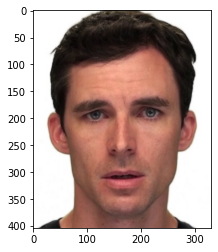

In [39]:
im = cv2.imread('test.jpg')
test_data = train.preprocess_image(im).to(device)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

model.load_state_dict(torch.load("inferences/resnet34.pt"))
model.eval()
gender, age = model(test_data)
pred_gender = gender.cpu().detach().numpy()
pred_age = torch.argmax(age, dim=1).cpu().detach().numpy()
print('Predicted gender:', np.where(pred_gender[0][0] < 0.5, 'Male', 'Female'), pred_gender[0][0])
print('Predicted age:', train.get_age(pred_age)) 